In [1]:
from photonic_planar_code import PhotonicPlanarCode
from graph_operations import *
from visualization import *

In [2]:
L, W = (5, 5)
pz=0.05
px=0.05
rz=0.1
rx=0.1

code = PhotonicPlanarCode(L, W, boundaries=np.array([0, 1], dtype=bool), pz=pz, px=px, rz=rz, rx=rx)

{(1, 1): 1}
{(0, 3): 1, (0, 4): 1, (0, 5): 1, (1, 1): 1, (1, 2): 1, (1, 3): 1, (1, 4): 1, (2, 3): 1, (2, 4): 1, (2, 5): 1, (3, 0): 1, (3, 1): 1, (3, 5): 1}


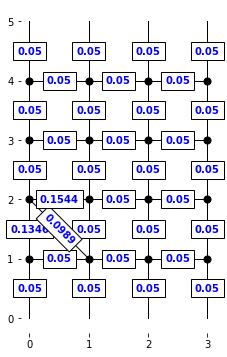

In [3]:
failed_sites = np.zeros(code.primal.shape, dtype=bool)
failed_sites[1,1] = True
code.measure_syndrome(failed_sites=failed_sites)
plot_error_probabilities(code.dual)

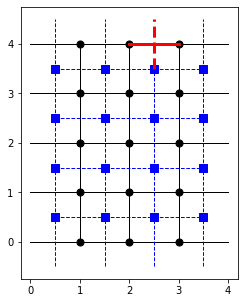

In [4]:
code.reset()
coords = (2,4,1)
code.dual.edges[coords] = True
dual_coords = code.primal_to_dual(coords, reverse=True)
code.primal.edges[dual_coords] = True
plot_planar_code(code, plot_dual=True, show_errors=True, show_syndrome=False)